In [153]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf  # Updated import statement
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [154]:
#Fetch historical stock data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

ticker = "MSFT"  # Change this to the desired stock symbol
start_date = "2018-07-21"  # Customize the start date
end_date = "2023-07-23"  # Customize the end date

stock_data = fetch_stock_data(ticker, start_date, end_date)
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-23,106.300003,108.139999,106.129997,107.970001,102.117790,29707000
2018-07-24,108.570000,108.820000,107.260002,107.660004,101.824577,26316600
2018-07-25,107.959999,111.150002,107.599998,110.830002,104.822762,30702100
2018-07-26,110.739998,111.000000,109.500000,109.620003,103.678368,31372100
2018-07-27,110.180000,110.180000,106.139999,107.680000,101.843529,37005300


In [155]:
stock_data1=stock_data.reset_index()['Close']

In [156]:
stock_data1

0       107.970001
1       107.660004
2       110.830002
3       109.620003
4       107.680000
           ...    
1253    345.730011
1254    359.489990
1255    355.079987
1256    346.869995
1257    343.769989
Name: Close, Length: 1258, dtype: float64

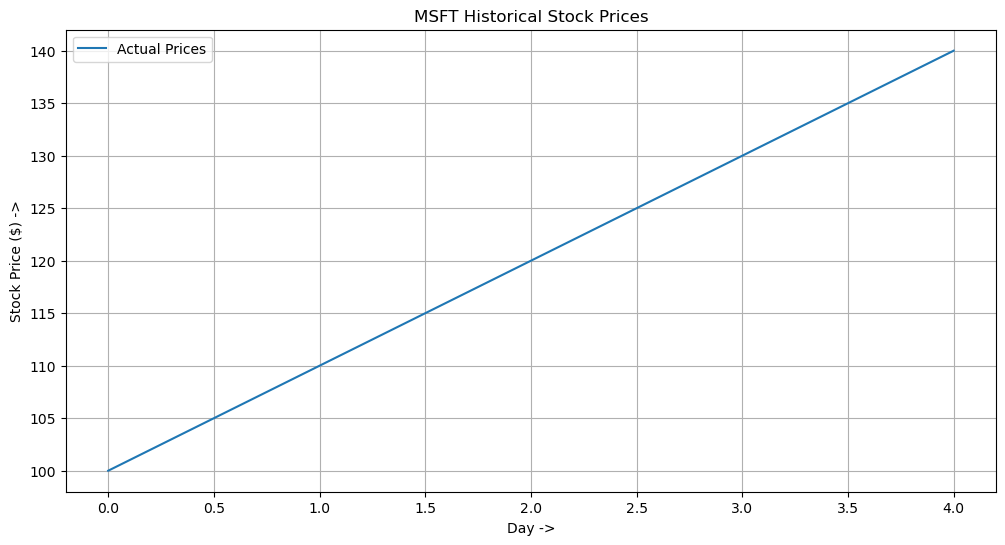

In [157]:
#Plot Historical Prices
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Prices")
plt.xlabel("Day ->")
plt.ylabel("Stock Price ($) ->")
plt.title(f"{ticker} Historical Stock Prices")
plt.legend()
plt.grid(True)
plt.show()

In [158]:
#Preprocess the data and prepare it for training
def preprocess_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1, 1))
    return scaled_data, scaler

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

sequence_length = 30  # Length of input sequences

In [159]:
#Prepare data for training
stock_prices, scaler = preprocess_data(stock_data)
X, y = create_sequences(stock_prices, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

In [160]:
#Build and train the Stacked LSTM model
def build_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 30, 50)            10400     
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dense_16 (Dense)            (None, 25)                1275      
                                                                 
 dense_17 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [161]:
#Train the model
epochs = 100
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/100
28/28 [==============================] - 8s 87ms/step - loss: 0.0245 - val_loss: 0.0068
Epoch 2/100
28/28 [==============================] - 1s 34ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 3/100
28/28 [==============================] - 1s 26ms/step - loss: 7.8197e-04 - val_loss: 0.0025
Epoch 4/100
28/28 [==============================] - 1s 22ms/step - loss: 6.8906e-04 - val_loss: 0.0021
Epoch 5/100
28/28 [==============================] - 1s 21ms/step - loss: 6.6542e-04 - val_loss: 0.0025
Epoch 6/100
28/28 [==============================] - 1s 21ms/step - loss: 7.0590e-04 - val_loss: 0.0020
Epoch 7/100
28/28 [==============================] - 1s 21ms/step - loss: 6.8045e-04 - val_loss: 0.0018
Epoch 8/100
28/28 [==============================] - 1s 21ms/step - loss: 6.3865e-04 - val_loss: 0.0020
Epoch 9/100
28/28 [==============================] - 1s 20ms/step - loss: 6.4990e-04 - val_loss: 0.0016
Epoch 10/100
28/28 [==============================] - 1s 21ms/step - los

In [162]:
#Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 8ms/step


In [163]:
#Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [164]:
#Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

214.70473946087301

In [165]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

272.97608117583655

In [166]:
#Make predictions for the next 30 days
def predict_next_30_days(model, data, scaler):
    last_sequence = data[-sequence_length:]
    predicted_prices = []
    for _ in range(30):
        next_price = model.predict(last_sequence.reshape(1, sequence_length, 1))
        predicted_prices.append(next_price[0, 0])
        last_sequence = np.append(last_sequence[1:], next_price[0, 0])
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

predicted_prices = predict_next_30_days(model, X_test[-1], scaler)

1/1 [==============================] - 0s 28ms/step


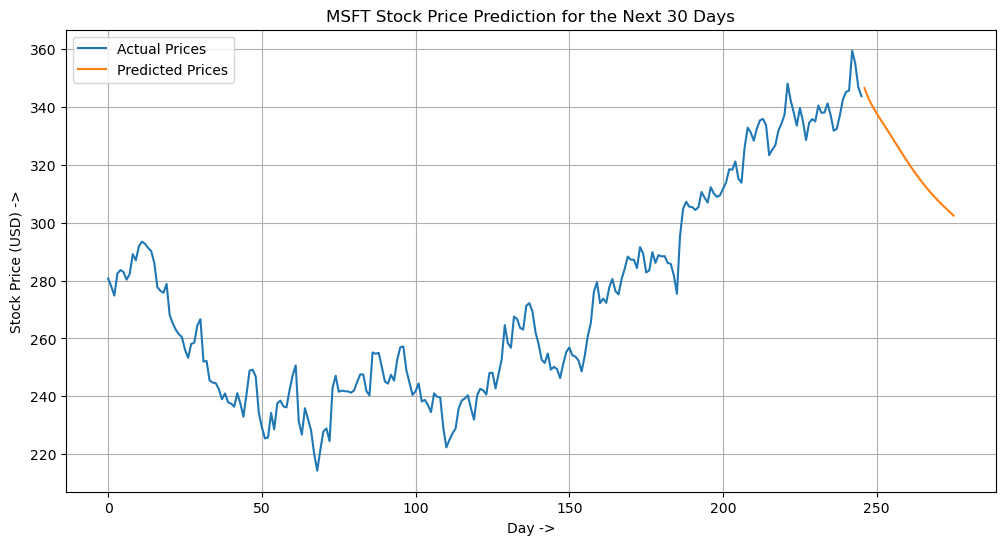

In [167]:
#Visualize the results
def plot_results(actual_prices, predicted_prices, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(actual_prices, label="Actual Prices")
    plt.plot(range(len(actual_prices), len(actual_prices) + len(predicted_prices)), predicted_prices, label="Predicted Prices")
    plt.xlabel("Day ->")
    plt.ylabel("Stock Price (USD) ->")
    plt.title(f"{ticker} Stock Price Prediction for the Next 30 Days")
    plt.legend()
    plt.grid(True)
    plt.show()

actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
plot_results(actual_prices, predicted_prices, ticker)